# Variability in pharmacokinetics
Pharmacokinetics is the study of how a drug moves through the body. The four primary aspects of pharmacokinetics are absorption, distribution, metabolism, and excretion (ADME). Pharmacokinetic variability refers to the differences in drug response among individuals due to various factors. Understanding these factors is crucial for optimizing drug therapy and achieving personalized medicine. 

![Interindividual variability](08_variability_subjects.png)

Here are key points about the factors that result in pharmacokinetic variability:

1. **Variability in Protein Amounts of Transporters and Enzymes**:
   - **Role of Proteins**: Proteins play a critical role in drug transportation and metabolism. Transporter proteins help move drugs across cell membranes, while metabolic enzymes break down drugs in the body.
   - **Genetic Factors**: The expression levels and activity of these proteins can vary significantly among individuals due to genetic variations. For example, cytochrome P450 enzymes, responsible for metabolizing many drugs, can have genetic polymorphisms leading to different metabolic rates.
   - **Disease States**: Conditions such as liver or kidney disease can alter the expression and function of these proteins, impacting drug pharmacokinetics.
   - **Interactions**: Substances like grapefruit juice can inhibit certain enzymes, affecting drug metabolism.

2. **Pharmacogenomic Variants**:
   - **Genetic Makeup**: Pharmacogenomics studies how genetic differences affect drug response. Variations in genes encoding drug-metabolizing enzymes, transporters, and receptors can influence drug efficacy and toxicity.
   - **Examples**: Individuals with certain variants of the CYP2D6 gene may metabolize drugs like codeine either too quickly or too slowly, leading to ineffective treatment or adverse effects.

3. **Physiological Factors**:
   - **Age**: Older adults typically have decreased organ function and altered body composition, affecting drug metabolism and distribution.
   - **Sex**: Men and women may metabolize drugs differently due to hormonal differences and body composition.
   - **Body Weight**: Drug dosing often needs to be adjusted based on body weight to achieve the desired therapeutic effect.
   - **Organ Function**: Impaired liver or kidney function can significantly affect drug metabolism and excretion.
   - **Health Status**: Chronic conditions like diabetes or heart disease can alter drug pharmacokinetics.

4. **Environmental Factors**:
   - **Diet**: Certain foods can interact with drugs, influencing their absorption and metabolism. For instance, high-fat meals can enhance the absorption of lipophilic drugs.
   - **Lifestyle**: Alcohol consumption, smoking, and exposure to environmental toxins can induce or inhibit drug-metabolizing enzymes, altering drug levels in the body.
   - **Example**: Smoking induces CYP1A2, which can increase the metabolism of certain drugs like theophylline.

5. **Drug-Drug Interactions**:
   - **Mechanisms**: Some drugs can inhibit or induce the enzymes that metabolize other drugs, leading to altered drug levels and potential adverse effects.
   - **Examples**: Co-administration of ritonavir with other protease inhibitors can boost their levels by inhibiting their metabolism.

6. **Patient Compliance**:
   - **Adherence**: How well a patient follows their prescribed medication regimen can significantly impact drug efficacy. Missed doses, incorrect timing, or improper administration can all affect drug pharmacokinetics.
   - **Strategies**: Educating patients about the importance of adherence and simplifying dosing regimens can improve compliance.

### Importance of Understanding Pharmacokinetic Variability

Understanding these factors is critical in personalized medicine as it allows for the optimization of drug therapy based on an individual's unique characteristics. This leads to improved drug efficacy, reduced adverse effects, and better overall patient outcomes. Healthcare professionals must consider these variables when prescribing medications and monitoring therapeutic responses.

## Variability in Protein Amounts of Transporters and Proteins
A large part of the variability in drug metabolism within the population is due to individual protein amounts.

![Protein variability](08_variability_proteins.png)

![Absorption Elimination Model](04_simple_absorption.png)

### Defining the Protein Distribution

To model the variability in protein amounts, we first need to define the distribution from which we will sample. We use a lognormal distribution for this purpose, as it is well-suited for representing biological data, including protein concentrations, which often exhibit right-skewed distributions.

A lognormal distribution is defined such that the logarithm of the variable is normally distributed. This characteristic makes it ideal for modeling data that cannot be negative and that exhibit multiplicative rather than additive variability.

For more details on the lognormal distribution and its properties, you can refer to the [scipy.stats.lognorm documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html).

### Why Use a Lognormal Distribution?

- **Biological Relevance**: Protein concentrations in biological systems are often right-skewed and span several orders of magnitude, characteristics that are well-captured by a lognormal distribution.
- **Non-Negativity**: Since protein amounts cannot be negative, the lognormal distribution is appropriate because it is defined for positive values only.
- **Multiplicative Effects**: Biological processes that affect protein levels (such as gene expression and degradation) often have multiplicative effects, aligning well with the lognormal distribution.

By using a lognormal distribution, we can more accurately model and simulate the variability observed in protein amounts across different samples or populations.

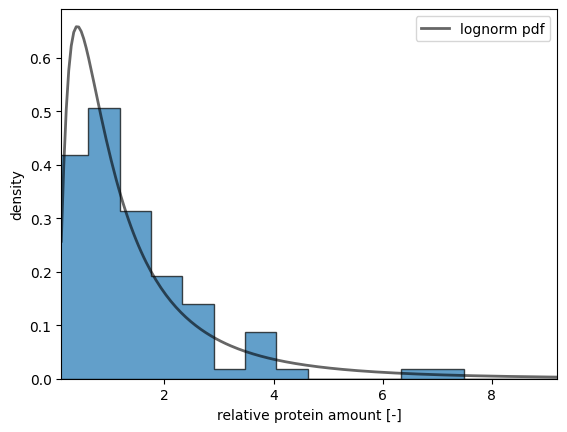

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm
np.random.seed(1234) # random seed for reproducibility

s = 0.954

# define the range and calculate the probability density function (pdf):
x = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), num=200)
y = lognorm.pdf(x, s)

# sample from distribution
n_samples = 100
f_proteins = lognorm.rvs(s, size=n_samples)

# plot a histogram of samples
fig, ax = plt.subplots()
ax.hist(f_proteins, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black")
# plot the exact distribution
ax.plot(x, y, 'k-', lw=2, alpha=0.6, label='lognorm pdf')
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best')
ax.set_xlabel("relative protein amount [-]")
ax.set_ylabel("density")
plt.show()

## Calculating Individual Pharmacokinetics

Next, we simulate the resulting distribution of pharmacokinetics based on the protein distribution. In our example, we sample the protein amount of a transporter responsible for the renal excretion of the drug. By sampling from the lognormal distribution of this protein's amounts, we can model how variability in its expression impacts pharmacokinetic parameters such as absorption, distribution, metabolism, and excretion. This approach allows us to understand and predict the range of pharmacokinetic behaviors in a population, considering individual differences in protein expression.

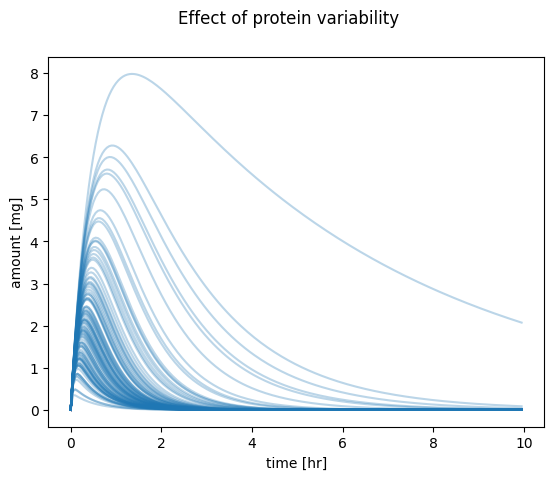

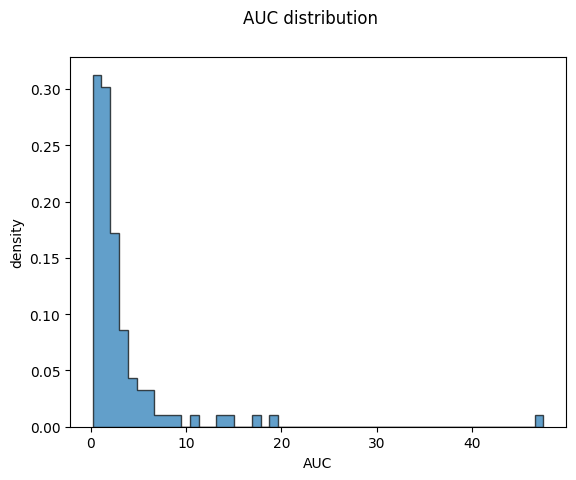

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate pharmacokinetics for indivdual proteins
tcs = []
pks = []

for f_protein in f_proteins:
    
    # the genetic variants effect the elimination/transport rate
    ke_protein = f_protein * ke 
    x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_protein))
    df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
    df["time"] = t
    tcs.append(df)
    
    # calculate pharmacokinetics parameters on the curves
    pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
    pks.append(pk)

    
# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Effect of protein variability")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")

for k, f_protein in enumerate(f_proteins):
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, color="tab:blue", alpha=0.3)
plt.show()

# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC distribution")
aucs = [pk["auc"] for pk in pks]
ax.hist(aucs, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black")

ax.set_xlabel("AUC")
ax.set_ylabel("density")
plt.show()

### Exercise: Analyzing the Distribution of Pharmacokinetic Parameters

**Objective**: Investigate how the distribution of a protein transporter responsible for renal excretion affects other pharmacokinetic parameters in the population. This includes parameters such as the half-life $t_{1/2}$ or elimination rate constant $k_{el}$, and others.

**Steps**:

1. **Sample Protein Amounts**: Sample from the lognormal distribution of the protein transporter responsible for renal excretion.
2. **Calculate Pharmacokinetic Parameters**: Use the sampled protein amounts to calculate various pharmacokinetic parameters. For instance:
    - **Half-life $t_{1/2}$
    - **Elimination Rate Constant $k_{el}$**
3. **Plot Histograms**: Generate histograms for these pharmacokinetic parameters to visualize their distributions in the population.

### Insights

By plotting these histograms, we can:
- **Visualize Variability**: Understand how variability in protein transporter expression translates to variability in pharmacokinetic parameters.
- **Predict Population Behavior**: Predict the range of pharmacokinetic responses in a population, which is critical for dosing strategies.
- **Inform Personalized Medicine**: Use this information to tailor drug therapies based on individual differences in protein expression and pharmacokinetic responses.

## Achieving the Therapeutic Range

Achieving the therapeutic range is crucial for ensuring that a drug is both effective and safe. The therapeutic range refers to the concentration window within which a drug produces its desired effect without causing significant adverse effects. Various factors, including pharmacokinetic variability, influence a drug's ability to stay within this range. Understanding and managing these factors are essential for optimizing drug dosing and maximizing therapeutic efficacy.

In [3]:
def simulate_multi_dosing(Dose_A, ka, ke):
    """Helper function to run the multiple dosing simulation."""

    # initial condition
    names = ["A_tablet", "A_central", "A_urine"]
    x0 = [
        Dose_A,  # A_tablet  [mg]
        0.0,   # A_central [mg]
        0.0,   # A_urine [mg]
    ]

    # time span for single dose
    t = np.linspace(0, 24, num=100) # [hr]

    # multiple dose simulation
    n_doses = 10  # [hr]
    
    dfs = []
    for k in range(n_doses):
        if k == 0:
            # x0[0] = 400   # first dose
            tvec = t.copy()
        elif k > 0:
            x0 = x[-1, :]
            x0[0] = x0[0] + Dose_A
            tvec = t.copy() + tvec[-1]

        x = odeint(dxdt_absorption_first_order, x0, tvec, args=(ka, ke))
        df = pd.DataFrame(x, columns=names)
        df["time"] = tvec
        dfs.append(df)

    df_all = pd.concat(dfs)
    return df_all

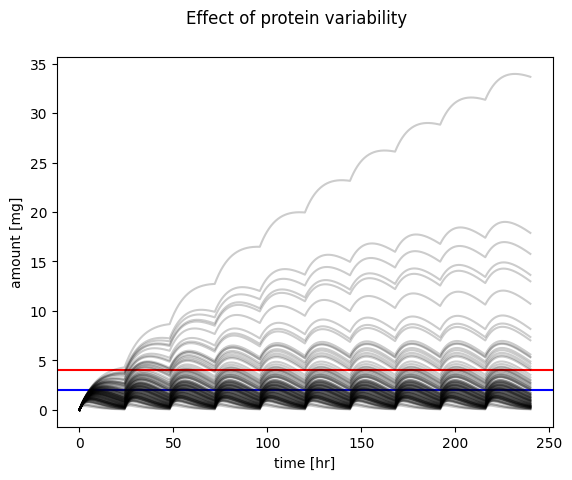

In [4]:
# run simulation and plot results
Dose_A = 5.0  # [mg]
ka = 0.1  # [1/hr]
ke = 0.1  # [1/hr]


# simulate multi dosing
tcs = []
pks = []
for f_protein in f_proteins:
    # individual elimination rate
    ke_protein = f_protein * ke 
    df = simulate_multi_dosing(Dose_A, ka, ke_protein)
    tcs.append(df)

# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Effect of protein variability")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")
ax.axhline(y=4, color='r', linestyle='-', label="MTC")
ax.axhline(y=2, color='b', linestyle='-', label="MEC")

for k, f_protein in enumerate(f_proteins):
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, color="black", alpha=0.2)
plt.show()

### Exercise: Dosing Optimization for the Population

**Objective**: Perform a dosing optimization for the population by adjusting the absorption rate constant $k_a$, the elimination rate constant $k_e$, and the administered dose $Dose_A$ to achieve optimal therapeutic outcomes.

### Insights

- **Optimization Process**: Understand the process of optimizing pharmacokinetic parameters to achieve therapeutic goals.
- **Parameter Interdependence**: Learn how changes in one parameter affect the overall pharmacokinetic profile and how to balance multiple parameters for optimal therapy.
- **Therapeutic Outcomes**: Ensure drug concentrations remain within the therapeutic range for the majority of the population, maximizing efficacy and minimizing adverse effects.

This exercise helps you gain practical experience in pharmacokinetic modeling and dosing optimization, crucial for personalized medicine and effective drug therapy. It helps to understand the difference between optimizing the theraphy for an individual versus the population.

## Stratification

In pharmacokinetic modeling, it is important to recognize that distributions of pharmacokinetic parameters can vary across different subsets of the population. This variability can be leveraged through stratification, which involves applying separate models to distinct subgroups within the population. 

### Gender-Based Stratification

For example, we can study the differences in pharmacokinetics between males and females by assuming that protein distributions differ between these groups. This approach allows us to more accurately predict drug behavior and optimize dosing for each subgroup. 

### Key Points:

- **Recognizing Differences**: Understand that pharmacokinetic parameters such as protein expression levels, enzyme activity, and drug transporter amounts can vary significantly between different demographic groups.
  
- **Subgroup Analysis**: By stratifying the population into subgroups (e.g., males and females), we can develop more precise pharmacokinetic models that account for these differences.
  
- **Improved Accuracy**: Stratified models can lead to better predictions of drug concentrations, efficacy, and safety profiles for each subgroup, enhancing personalized medicine.

### Example Application:

- **Gender Differences**: Protein distributions related to drug metabolism and transport can differ between males and females due to physiological and hormonal variations. By stratifying the population into male and female subgroups, we can tailor pharmacokinetic models to reflect these differences.
  
- **Implications for Dosing**: Stratification allows for more accurate dose adjustments based on subgroup-specific characteristics, reducing the risk of under- or over-dosing and improving therapeutic outcomes.

By incorporating stratification into pharmacokinetic modeling, we can enhance our understanding of drug behavior across different population subsets and optimize treatment strategies accordingly.

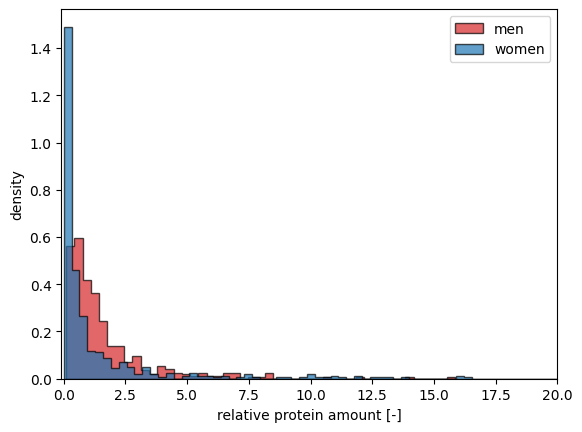

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

fig, ax = plt.subplots(1, 1)
s_men = 1
scale_men=1
scale_women=0.4
s_women = 2

n_samples = 500
f_proteins_men = lognorm.rvs(s_men, scale=scale_men, size=n_samples)
f_proteins_women = lognorm.rvs(s_women, scale=scale_women, size=n_samples)

ax.hist(f_proteins_men, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black", color="tab:red", label="men")
ax.hist(f_proteins_women, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
        edgecolor="black", color="tab:blue", label="women")

ax.legend(loc='best')
ax.set_xlabel("relative protein amount [-]")
ax.set_ylabel("density")
ax.set_xlim(left=-0.1, right=20)
plt.show()
# print(f_proteins)

/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/home/mkoenig/git/course-pharmacokinetic-modelling/src/mb19/notebooks/helpers.py:33: RuntimeWarning: invalid value encountered in log
  y = np.log(c[max_index + 1:])
/hom

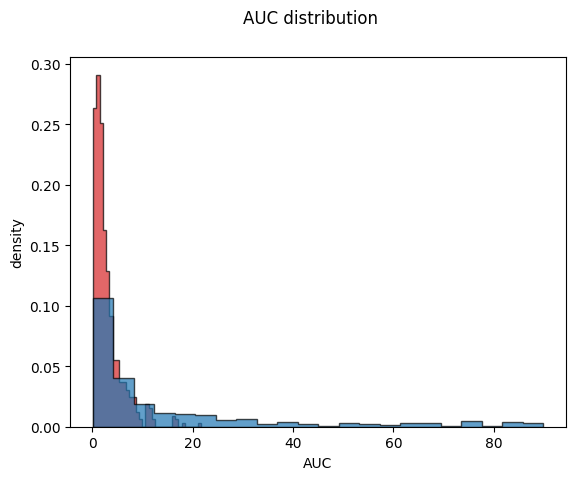

In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate all genetic variants
tcs_dict = {}
pks_dict = {}

for key in ["men", "women"]:
    tcs = []
    pks = []

    if key == "men":
        f_proteins = f_proteins_men
    elif key == "women":
        f_proteins = f_proteins_women
    
    for f_protein in f_proteins:

        # the genetic variants effect the elimination/transport rate
        ke_protein = f_protein * ke 
        x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_protein))
        df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
        df["time"] = t
        tcs.append(df)

        # calculate pharmacokinetics parameters on the curves
        pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
        pks.append(pk)
    tcs_dict[key] = tcs
    pks_dict[key] = pks
    
# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC distribution")
for key in ["men", "women"]:
    pks = pks_dict[key]

    if key == "men":
        color = "tab:red"
    elif key == "women":
        color = "tab:blue"
    
    aucs = [pk["auc"] for pk in pks]
    ax.hist(aucs, density=True, bins='auto', histtype='stepfilled', alpha=0.7, 
            edgecolor="black", color=color)

ax.set_xlabel("AUC")
ax.set_ylabel("density")
plt.show()

## Pharmacogenetic Variants
Pharmacogenomics is the study of how an individual's genetic makeup influences their response to drugs. This field combines pharmacology (the science of drugs) and genomics (the study of genes and their functions) to develop effective, safe medications and doses that will be tailored to a person's genetic makeup.

Pharmacogenomics is a part of the broader field of personalized medicine, which aims to tailor medical treatment to the individual characteristics of each patient.

With respect to pharmacokinetics (the study of how the body absorbs, distributes, metabolizes, and excretes drugs), pharmacogenomics can provide valuable insights. For instance:

1. **Absorption and Distribution:** Genetic differences can affect the expression and function of proteins involved in drug transport across cell membranes, influencing how quickly and effectively a drug is absorbed or distributed within the body.

2. **Metabolism:** A key aspect of pharmacokinetics is understanding how drugs are metabolized, primarily by enzymes in the liver. Individual genetic variations can affect the activity of these enzymes, leading to differences in how quickly a drug is metabolized. For example, some individuals may have genetic variations that cause certain enzymes to be overly active ("ultra-metabolizers") or underactive ("poor metabolizers"). This can significantly impact the concentration of drug in the body and therefore its efficacy and potential for side effects.

3. **Excretion:** Variations in genes can also impact the function of proteins involved in the excretion of drugs, primarily in the kidneys, affecting the rate at which a drug is removed from the body.

By understanding an individual's pharmacogenomic profile, healthcare providers can better predict how a patient will respond to a particular drug, informing decisions about which drug to prescribe and at what dose. This can improve drug efficacy, reduce the risk of adverse effects, and contribute to more efficient and safer healthcare. However, it's important to note that while pharmacogenomics holds great promise, its application in routine clinical practice is currently limited, though it's an area of active research and development.

The following defines the activity of the allels of the SLCO1B1 transporter.
We focus on the subset of important genetic variants `*1a`, `*1b`, `*15` and possible combinations

In [7]:
# SLCO1B1
# f_sclo1b1
f_wildtype = 1.0  # *1a wildtype activity
f_increase = 1.1  # *1b has slightly increased activity
f_decrease = 0.5  # all variants with the 521T/C mutant have strongly reduced activity, e.g., *15

slco1b1_activity = {
    # strong increase (dark blue)
    "*1b/*1b": (f_increase + f_increase) / 2,
    
    # mild increase (light blue)
    "*1a/*1b": (f_wildtype + f_increase) / 2,
    
    # wildtype (black)
    "*1a/*1a": (f_wildtype + f_wildtype)/2,
    
    # minor decrease (orange)
    "*1b/*15": (f_increase + f_decrease) / 2,
    
    # mild decrease (red)
    "*1a/*15": (f_wildtype + f_decrease) / 2,

    # strong decrease (dark red)
    "*15/*15": (f_decrease + f_decrease) / 2,
}
slco1b1_color = {
        "*1b/*1b": "blue",
        "*1a/*1b": "tab:blue",
        "*1a/*1a": "black",
        "*1b/*15": "tab:orange",
        "*1a/*15": "tab:red",
        "*15/*15": "red",
}

![Absorption Elimination Model](04_simple_absorption.png)

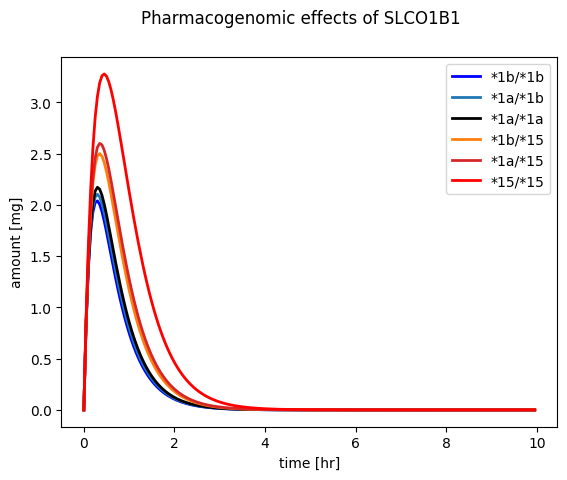

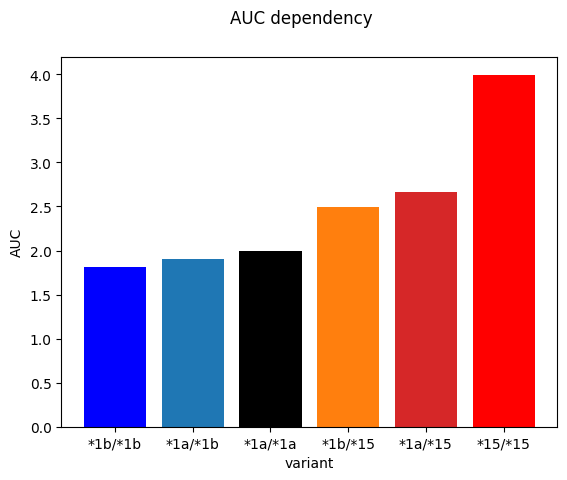

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from matplotlib import pylab as plt

from helpers import f_pk, dxdt_absorption_first_order

# initial condition and time span
t = np.arange(0, 10, 0.05) # [hr]
Dose_A = 10.0  # [mg]
x0 = [
    Dose_A,  # A_tablet  [mg]
    0.0,   # A_central [mg]
    0.0,   # A_urine [mg]
]

# parameters
ka = 2.0  # [1/hr]
ke = 5.0  # [1/hr]

# simulate all genetic variants
tcs = []
pks = []

for variant, f_activity in slco1b1_activity.items():
    
    # the genetic variants effect the elimination/transport rate
    ke_variant = f_activity * ke 
    x = odeint(dxdt_absorption_first_order, x0, t, args=(ka, ke_variant))
    df = pd.DataFrame(x, columns=["A_tablet", "A_central", "A_urine"])
    df["time"] = t
    tcs.append(df)
    
    # calculate pharmacokinetics parameters on the curves
    pk = f_pk(t=df.time.values, c=df.A_central.values, dose=Dose_A, show=False)
    pks.append(pk)

    
# plot timecourse
f, ax = plt.subplots(nrows=1, ncols=1)    
f.suptitle("Pharmacogenomic effects of SLCO1B1")
ax.set_xlabel("time [hr]")
ax.set_ylabel("amount [mg]")

for k, variant in enumerate(slco1b1_activity):
    color = slco1b1_color[variant]
    tc = tcs[k]
    ax.plot(tc.time, tc.A_central, linewidth=2, color=color, label=variant)

ax.legend()
plt.show()

# plot AUC
f, ax = plt.subplots(nrows=1, ncols=1)
f.suptitle("AUC dependency")

aucs = [pk["auc"] for pk in pks]
variants = list(slco1b1_activity.keys())
colors = [slco1b1_color[v] for v in variants]

ax.bar(
    x=range(len(aucs)), height=aucs, 
    color=colors, 
    tick_label=variants
)
ax.set_xlabel("variant")
ax.set_ylabel("AUC")


plt.show()

**Exercise 1**: Study the effect of the genetic variants on other pharmacokinetic parameters such as CL, thalf, ...

**Exercise 2**: Add an additional newly discovered variant `*f` to the analysis which has 2.0 activity compared to the wildtype variant.